In [1]:
import numpy as np
import pandas as pd
import datetime
from dateutil.relativedelta import relativedelta

import matplotlib.pyplot as plt
%matplotlib inline


# Задание 1

In [2]:
eggs = pd.read_csv('data/price-of-a-dozen-eggs.csv', index_col='Year', parse_dates=['Year'])

In [3]:
eggs.head()

,Price of a dozen eggs
Year,
1900-01-01,276.79
1901-01-01,315.42
1902-01-01,314.87
1903-01-01,321.25
1904-01-01,314.54


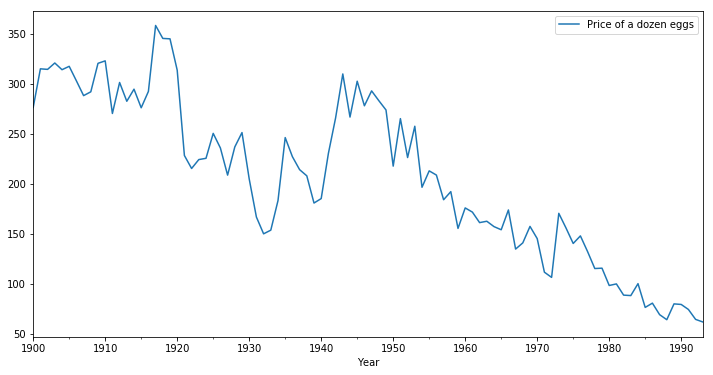

In [4]:
eggs.plot(figsize=(12,6))
plt.show()

In [5]:
from statsmodels.tsa.stattools import adfuller
print("Критерий Дики-Фуллера: p=%f" % adfuller(eggs['Price of a dozen eggs'])[1])

Критерий Дики-Фуллера: p=0.656828


<div class="alert alert-info">

<h4> Задание 1. Выполнять в отдельном файле</h4>
<p></p>
<ol>
<li>Попробуйте привести исходный ряд к стационарному путем вычитания из него тренда. Для этого можете воспользоваться функцией scipy.linalg.solve. В качестве значений $a$ выступают моменты времени $t=0,1,...,n$, где $n$ $-$ длина ряда, а в качестве $b$ $-$ значения ряда. Выражение $a \times x$ будет описывать тренд.</li>
    <p></p>
<li>С помощью критерия Дики-Фуллера проверьте наличие единичных корней. Выведите график полученного ряда. Является ли полученный ряд стационарным?</li>
    <p></p>
<li>Продифференцируйте исходный ряд. Выведите p-value критерия Дики-Фуллера и постройте график полученного ряда. Какое преобразование является более предпочтительным и почему?</li>
</ol>
</div>

<p></p>
</div>

### 1.1

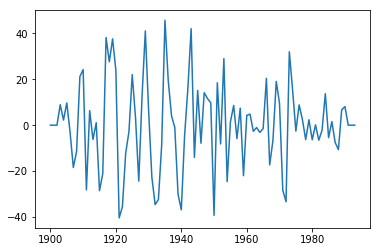

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

ss_decomposition = seasonal_decompose(x=eggs['Price of a dozen eggs'], model='additive', period = 6)
est_trend = ss_decomposition.trend
est_seasonal = ss_decomposition.seasonal
est_residual = ss_decomposition.resid

without_trend = (eggs['Price of a dozen eggs'] - est_trend).fillna(0)
plt.plot(without_trend)

### 1.2

In [7]:
adf_after, pvalue_after, usedlag_, nobs_, critical_values_, icbest_ = adfuller(without_trend)
print("ADF: ", adf_after)
print("p-value: ", pvalue_after)

ADF:  -6.688834235679435
p-value:  4.159265038449695e-09


Вывод: по критерию adfuller ряд является стационарным, но это не совсем так, так как дисперсия непостоянна

### 1.3

In [8]:
pvalue = 1
best_i = 0
for i in range(1,12):
    adf_after, pvalue_after, usedlag_, nobs_, critical_values_, icbest_ = adfuller(eggs['Price of a dozen eggs'].diff(i).fillna(0))
    if pvalue_after < pvalue:
        best_i =i
        pvalue = pvalue_after
print(pvalue,best_i)

5.339629651255791e-20 1


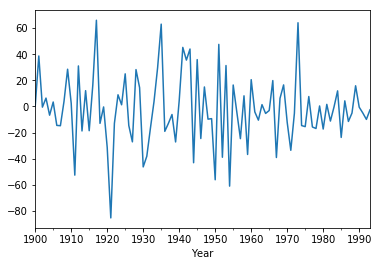

In [9]:
eggs['Price of a dozen eggs'].diff(1).fillna(0).plot()

Вывод: по критерию ряд стационарен, что и видно по картинке. И лучше показатель adfuller у дифференцирования.

# 2

In [10]:
passengers = pd.read_csv('data/passengers.csv', index_col=0, parse_dates=True)

In [11]:
passengers.head()

,num_passengers
date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


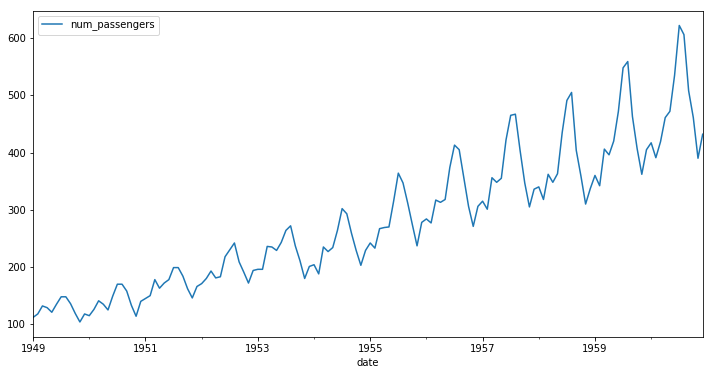

In [12]:
passengers.plot(figsize=(12,6))
plt.show()

### Приведение к стационарному ряду

In [13]:
from scipy.stats import boxcox
from statsmodels.tsa.stattools import adfuller

In [14]:
passengers_transformed, lmbda = boxcox(passengers['num_passengers'])

Стабилизация дисперсии

In [15]:
y_transformation = pd.DataFrame(passengers['num_passengers'].values, columns=['initial'])
y_transformation['transformed'] = passengers_transformed

In [16]:
y_transformation['seasonal_diff'] = y_transformation['transformed'].diff(12)

In [17]:
y_transformation['lag1_diff'] = y_transformation['seasonal_diff'].diff(1)

In [18]:
print("Критерий Дики-Фуллера для исходного ряда: p=%f" % adfuller(y_transformation['initial'])[1])
print("После преобразования Бокса-Кокса: p=%f" % adfuller(y_transformation['transformed'])[1])
print("После сезонного дифференцирования: p=%f" % adfuller(y_transformation['seasonal_diff'].dropna())[1])
print("После дополнительного дифференцирования: p=%f" % adfuller(y_transformation['lag1_diff'].dropna())[1])

Критерий Дики-Фуллера для исходного ряда: p=0.991880
После преобразования Бокса-Кокса: p=0.617162
После сезонного дифференцирования: p=0.052505
После дополнительного дифференцирования: p=0.000304


In [19]:
y_transformation.head(15)

,initial,transformed,seasonal_diff,lag1_diff
0,112,6.827490,NaN,NaN
1,118,6.932822,NaN,NaN
2,132,7.161892,NaN,NaN
3,129,7.114611,NaN,NaN
4,121,6.983787,NaN,NaN
5,135,7.208265,NaN,NaN
6,148,7.399598,NaN,NaN
7,148,7.399598,NaN,NaN
8,136,7.223528,NaN,NaN
9,119,6.949932,NaN,NaN


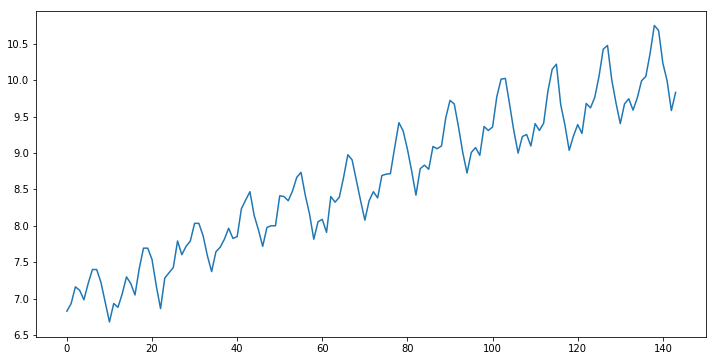

In [20]:
plt.rcParams['figure.figsize'] = (12,6)
plt.plot(y_transformation['transformed'] )

plt.show()

Рассмотрим коррелограмму полученного ряда.

In [21]:
from statsmodels.graphics.tsaplots import plot_acf

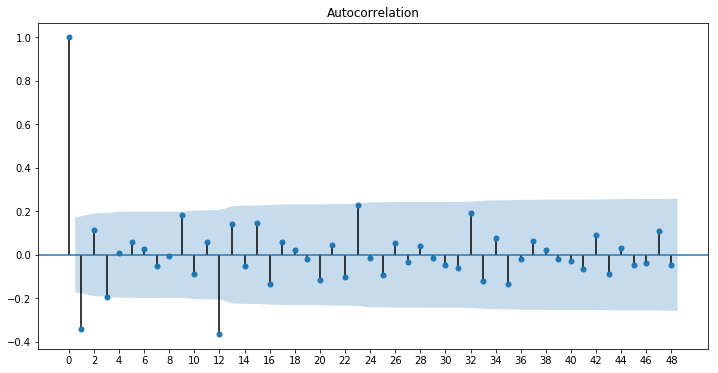

In [22]:
plt.rcParams['figure.figsize'] = (12,6)
plot_acf(y_transformation['lag1_diff'].dropna(), lags=48)
plt.xticks(np.arange(0, 50, 2))
plt.show()

## Задание 3

<div class="alert alert-info">

<h4> Задание 3. Реализация модели AR</h4>
<p></p>
Для полученного стационарного ряда объемов пассажирских авиаперевозок вычислить значение частичной автокорреляции с лагом 3. Для этого необходимо реализовать модель авторегрессии (самостоятельно, без применения средств statsmodels).

<p></p>
</div>

Для определения значения частичной автокорреляции с лагом 3 необходимо построить авторегрессию порядка 2 ($AR(2)$), вычесть эту авторегрессию из ряда и вычислить автокорреляцию на полученных остатках, т.е.:

### Стационарный ряд

In [23]:
stationary = y_transformation['lag1_diff'].dropna().values

### AR Model

In [24]:
from scipy.optimize import minimize

In [25]:
def AR_MSE(a,x):
    p = len(a) - 1
    N = len(x)
    b = np.zeros(N)
    for i in range(p,N):
        b[i] = a[0] + np.sum(a[1::]*x[i-p:i])
        #b[i] = a[0] + a[1]*x[i-1] + a[2]*x[i-2]
    return np.sum((b[p::]-x[p::])**2)

def AR_result(a,x):
    p = len(a) - 1
    N = len(x)
    b = np.zeros(N)
    for i in range(p,N):
        b[i] = a[0] + np.sum(a[1::]*x[i-p:i])
        #b[i] = a[0] + a[1]*x[i-1] + a[2]*x[i-2]
    return b[p::]

def min_ar(r):
    res = minimize (lambda x: AR_MSE([x[0],x[1],x[2]],r), [0.5,0.5,0.5])
    return res.x,res.fun
    
best_params, mse = min_ar(stationary)

### Best Params

In [26]:
best_params

array([ 3.03019002e-04, -8.14098116e-03, -3.47795136e-01])

In [27]:
ar_fitted = AR_result(best_params,stationary )

### Вычитаем авторегрессию

In [28]:
minus_ar = stationary [2::] - ar_fitted

### Вычисляем автокорреляцию

In [29]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[result.size//2:]

In [30]:
autocorrelation = autocorr(minus_ar)

In [31]:
from statsmodels.graphics.tsaplots import plot_pacf

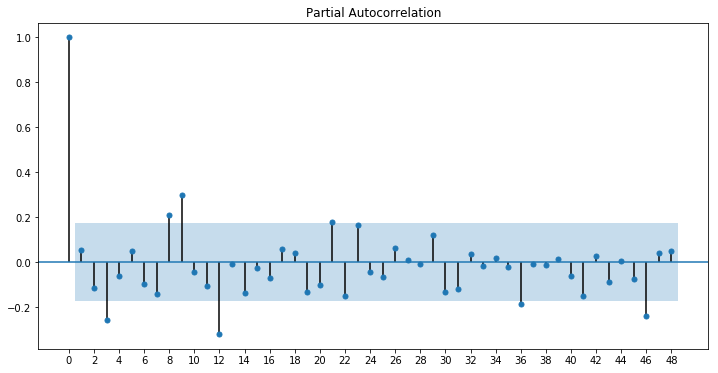

In [32]:
plt.rcParams['figure.figsize'] = (12,6)
plot_pacf(autocorrelation, lags=48)
plt.xticks(np.arange(0, 50, 2))
plt.show()

## Задание 4

<div class="alert alert-info">

<h4> Задание 4</h4>
<p></p>
<ol>
<li>Среди ранее полученных наборов гиперпараметров (parameters_list) найдите тот, для которого критерий Акаике минимален.</li>
    <p></p>
<li>С помощью функции predict (именно predict!) получите прогноз на 12 точек вперед.</li>
    <p></p>
<li>Выполните обратные преобразования, чтобы получить прогноз для исходного ряда. Отобразите исходный ряд и прогноз на графике.</li>
</ol>
</div>

<p></p>
</div>

### 4.1

In [33]:
from statsmodels.tsa.arima_model import ARIMA

In [34]:
stationary = y_transformation['lag1_diff'].dropna().values

In [35]:
import warnings; warnings.simplefilter('ignore')
import statsmodels as sm
from itertools import product

In [36]:
p,d,q = range(0, 3), 1, range(0, 3)

parameters = product(p, q)
parameters_list = list(parameters)
parameters_list

[(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)]

In [37]:
mdl = y_transformation['seasonal_diff'].dropna().values

In [38]:
res = []
best_aic = float("inf")
for param in parameters_list:
    try:
        model = ARIMA(mdl, order=(param[0], d, param[1])).fit()
    except ValueError:
        print('mistake:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    res.append([param, model.aic])

mistake: (1, 2)


In [39]:
result_table = pd.DataFrame(res)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True))

  parameters         aic
6     (2, 1) -240.999777
7     (2, 2) -240.071840
1     (0, 1) -238.264336
3     (1, 0) -237.655784
4     (1, 1) -236.419582
2     (0, 2) -236.314200
5     (2, 0) -235.664381
0     (0, 0) -223.288595


In [40]:
print(best_model.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  131
Model:                 ARIMA(2, 1, 1)   Log Likelihood                 125.500
Method:                       css-mle   S.D. of innovations              0.092
Date:                Sat, 21 Mar 2020   AIC                           -241.000
Time:                        22:18:02   BIC                           -226.624
Sample:                             1   HQIC                          -235.158
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.001     -0.318      0.751      -0.002       0.002
ar.L1.D.y      0.5571      0.086      6.509      0.000       0.389       0.725
ar.L2.D.y      0.2430      0.086      2.822      0.0

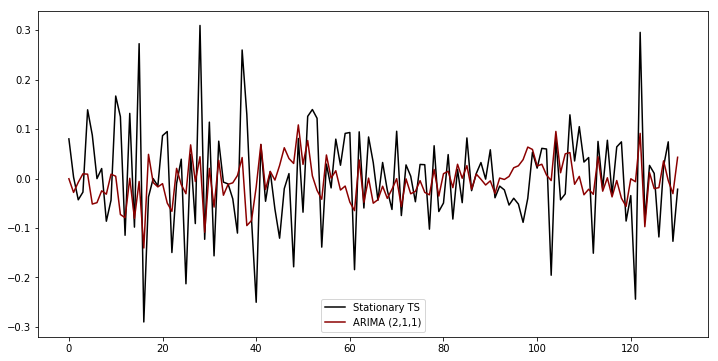

In [41]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(stationary,color = 'black',label = "Stationary TS")
ax.plot(best_model.fittedvalues, color='darkred',label = f"ARIMA ({best_param[0]},{d},{best_param[1]})")
plt.legend()
plt.show()

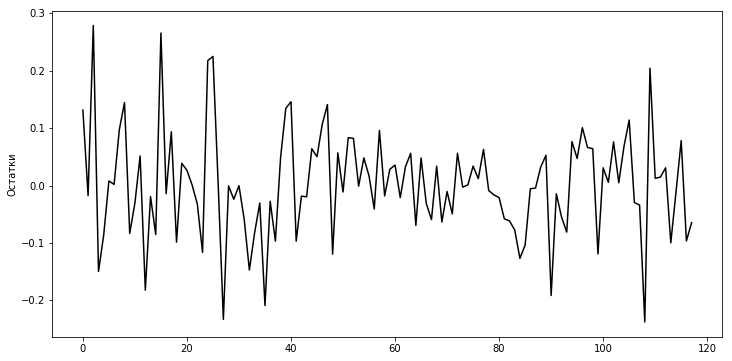

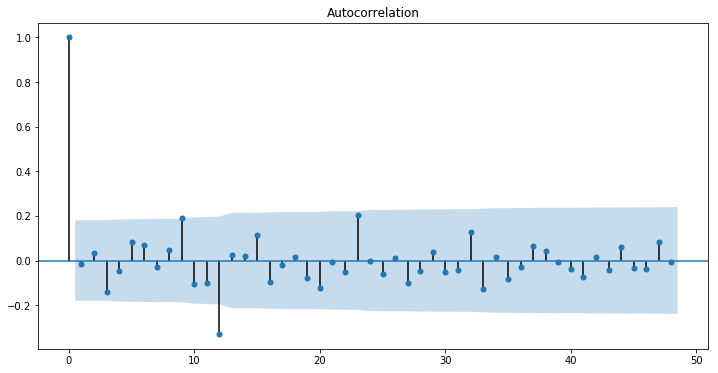

ДФ: p=0.001303


In [42]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(best_model.resid[13:],color = 'black',label = "Stationary TS")
ax.set_ylabel('Остатки')
plot_acf(best_model.resid[13:], lags=48)
plt.show()

print('ДФ: p=%f' % adfuller(best_model.resid[13:])[1])

### 4.2

In [43]:
future = best_model.predict(143)
dates = np.arange(132,144)

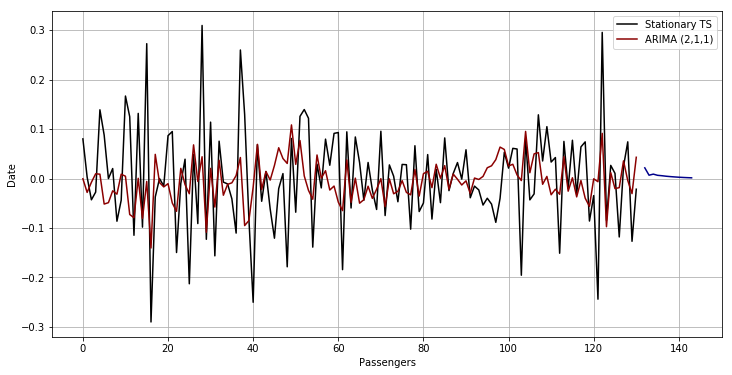

In [44]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(stationary,color = 'black',label = "Stationary TS")
ax.plot(best_model.fittedvalues, color='darkred',label = f"ARIMA ({best_param[0]},{d},{best_param[1]})")
ax.plot(dates,future,color = 'darkblue')
ax.set_ylabel('Date')
ax.set_xlabel('Passengers')
plt.grid()
plt.legend()
plt.show()

### 4.3

In [45]:
y_transformation['lag1_diff2']=np.concatenate(([np.nan]*13,best_model.fittedvalues))

#### 4.3.1 Возвращение к ряду по ARIMA

In [46]:
y_transformation['seasonal_diff_shift'] = y_transformation['seasonal_diff'].shift()
y_transformation['seasonal_diff_res'] = y_transformation['lag1_diff2'] + y_transformation['seasonal_diff_shift']
y_transformation.drop(['seasonal_diff_shift'], axis=1, inplace=True)
y_transformation['transformed_shift'] = y_transformation['transformed'].shift(12)
y_transformation.dropna(inplace=True)
y_transformation['transformed_res'] = y_transformation['seasonal_diff_res'] + y_transformation['transformed_shift']
y_transformation.drop('transformed_shift', axis=1, inplace=True)

In [47]:
def invboxcox(x, lmbda):
    if lmbda == 0:
        return np.exp(x)
    
    return np.exp( np.log ( lmbda * x + 1) / lmbda)

In [48]:
y_transformation['initial_res'] = invboxcox(y_transformation['transformed_res'], lmbda)

In [49]:
y_transformation.head(10)

,initial,transformed,seasonal_diff,lag1_diff,lag1_diff2,seasonal_diff_res,transformed_res,initial_res
13,126,7.066384,0.133562,0.080310,-0.000299,0.052952,6.985774,121.118294
14,141,7.298438,0.136547,0.002985,-0.027943,0.105618,7.267510,138.916958
15,135,7.208265,0.093655,-0.042892,-0.007508,0.129039,7.243649,137.327937
16,125,7.050091,0.066304,-0.027351,0.009702,0.103357,7.087144,127.284030
17,149,7.413715,0.205449,0.139146,0.008933,0.075236,7.283502,139.990717
18,170,7.692978,0.293380,0.087930,-0.051476,0.153974,7.553571,159.222148
19,170,7.692978,0.293380,0.000000,-0.048671,0.244709,7.644307,166.168640
20,158,7.537260,0.313732,0.020352,-0.024724,0.268656,7.492184,154.664107
21,133,7.177448,0.227516,-0.086215,-0.031478,0.282254,7.232185,136.569995
22,114,6.863124,0.183823,-0.043694,0.008912,0.236428,6.915729,117.008137


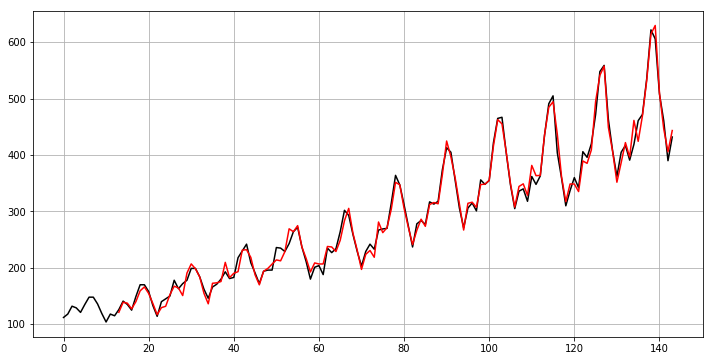

In [50]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(passengers['num_passengers'].values,color = 'black',label = "Passengers")
ax.plot(np.concatenate([np.full(13, np.nan), y_transformation['initial_res']]), color='red')
plt.grid()
plt.show()

#### 4.3.2 Прогноз

In [51]:
pss = passengers[['num_passengers']]

datelist = [datetime.datetime.strptime("1961-01-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,12)]
future = pd.DataFrame(index=datelist, columns= pss.columns)
pss = pd.concat([pss, future])

In [52]:
f = best_model.predict(143)

In [53]:
def fold_list(f, x, lst):
    if len(lst) != 0:
        return [x] + fold_list(f, f(x, lst[0]), lst[1:])
    else:
        return [x]

f= np.array(fold_list(lambda x, y: x + y, y_transformation['seasonal_diff'].iloc[-1], f))
f = y_transformation['transformed'].iloc[-12:].values + f[1:]
f = np.exp( np.log ( lmbda * f + 1) / lmbda)

In [54]:
f

array([448.61598316, 422.1168941 , 453.65041627, 499.89203507,
       512.863941  , 581.5256873 , 675.89576589, 659.56604896,
       554.74328822, 504.52003213, 428.10961182, 473.85190107])

In [55]:
pss["model"] = np.concatenate([np.full(13, np.nan), y_transformation['initial_res'],np.full(12, np.nan)])
pss["forecasting"] = np.concatenate([np.full(144,np.nan),f])
pss.head()

,num_passengers,model,forecasting
1949-01-01,112,NaN,NaN
1949-02-01,118,NaN,NaN
1949-03-01,132,NaN,NaN
1949-04-01,129,NaN,NaN
1949-05-01,121,NaN,NaN


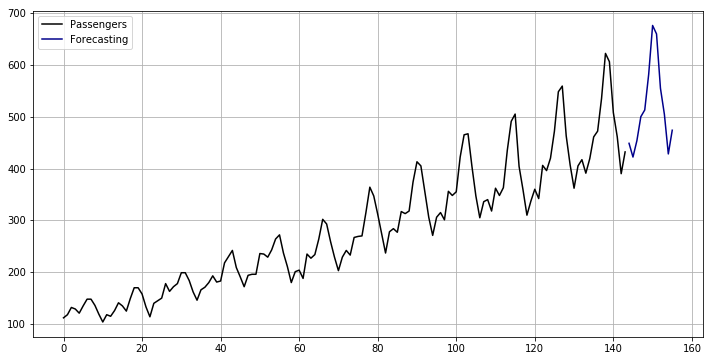

In [56]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(pss['num_passengers'].values,color = 'black',label = "Passengers")
ax.plot(pss['forecasting'].values, color='darkblue',label ='Forecasting')
plt.grid()
plt.legend()
plt.show()